# Understand student performance data set and fitting initial hierarchical models

_**Abstract**_: 

My research project aims to build parametric models with high interpretability on EdTech datasets. In my proposal, I proposed **hierarchical models** as a good way to both understand and predict student performance based on features collected using EdTech systems. 

My previous 2 weeks of project work focused on _**understand my dataset and build a hierarchical model with it**_. In this immediate milestone, I will walk through my dataset, my model building process and some initial results.

## Summary
I will first describe the data and quickly explore the data.  Next, I will try various visualizations which reveal some interesting thoughts. We then will try tree-based machine learning models to see what accuracy we could get with black-box models. Finally, we will try to fit a hierarchical logistic model with this data as alternative to tree-based models.

This notebook is long, so here is the layout of points covered:

* [Data overview](#data)
* [Data exploration](#exploration)
* [Tree-based models](#traditional)
* [Hierarchical models](#hierarchical)
     - [Motivation recap](#recap)
     - [Hierarchical logistic model](#hier_logit)
     - [Prediction accuracy](#prediction)     

<a id='generalnotes'></a>

<a id='data'></a>
## Data overview
This is an educational data set which is collected from learning management system (LMS) 
using a learner activity tracker tool, which called experience API (xAPI). The xAPI is a component of the training and learning architecture (TLA) that enables to monitor learning progress like reading an article or watching a training video. 

The experience API helps the learning activity providers to determine the learner, activity and objects that describe a learning experience. The dataset consists of 480 student records and 16 features. 

### Features
The features are classified into three major categories: 
* Demographic features such as gender and nationality. 
* Academic background features such as educational stage, grade Level and section. 
* Behavioral features such as raised hand on class, opening resources, answering survey by parents, and school satisfaction.

### Categorical summary
The dataset consists of 305 males and 175 females. The students come from different origins such as 179 students are from Kuwait, 172 students are from Jordan, 28 students from Palestine, 22 students are from Iraq, 17 students from Lebanon, 12 students from Tunis, 11 students from Saudi Arabia, 9 students from Egypt, 7 students from Syria, 6 students from USA, Iran and Libya, 4 students from Morocco and one student from Venezuela.

### Relevant Papers:
Amrieh, E. A., Hamtini, T., & Aljarah, I. (2016). Mining Educational Data to Predict Student’s academic Performance using Ensemble Methods. International Journal of Database Theory and Application, 9(8), 119-136.

Amrieh, E. A., Hamtini, T., & Aljarah, I. (2015, November). Preprocessing and analyzing educational data set using X-API for improving student's performance. In Applied Electrical Engineering and Computing Technologies (AEECT), 2015 IEEE Jordan Conference on (pp. 1-5). IEEE.

<a id='exploration'></a>
## Data Exploration
### Data clean-up and preparation
We have no missing values, which saves us a lot of time and uncertainty in making assumptions.

In [30]:
%matplotlib inline
import numpy as np
import pandas as pd
pd.options.display.max_columns = None

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
import seaborn as sns; sns.set_context('notebook')
import pystan

In [6]:
# Import data and start exploratory data analysis
df = pd.read_csv('../data/xAPI-Edu-Data.csv')

Some stats to get a general feeling of the data:

In [7]:
print "Size:", df.shape 
df.head(2)

Size: (480, 17)


,gender,NationalITy,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,raisedhands,VisITedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class
0,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,15,16,2,20,Yes,Good,Under-7,M
1,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,20,20,3,25,Yes,Good,Under-7,M


Some info

In [9]:
# Some of the columns seem to have random capitalizations 
df.rename(index=str, columns={'gender':'Gender', 'NationalITy':'Nationality',
                               'raisedhands':'RaisedHands', 'VisITedResources':'VisitedResources'},
                               inplace=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 480 entries, 0 to 479
Data columns (total 17 columns):
Gender                      480 non-null object
Nationality                 480 non-null object
PlaceofBirth                480 non-null object
StageID                     480 non-null object
GradeID                     480 non-null object
SectionID                   480 non-null object
Topic                       480 non-null object
Semester                    480 non-null object
Relation                    480 non-null object
RaisedHands                 480 non-null int64
VisitedResources            480 non-null int64
AnnouncementsView           480 non-null int64
Discussion                  480 non-null int64
ParentAnsweringSurvey       480 non-null object
ParentschoolSatisfaction    480 non-null object
StudentAbsenceDays          480 non-null object
Class                       480 non-null object
dtypes: int64(4), object(13)
memory usage: 67.5+ KB


Use the `merge` method to combine home- and county-level information in a single DataFrame.

This is the data we deal with. Hierarchy is defined by county. target/dependent variable is 'activity'
'Uppm' is the Uranium level at county level, one of the main predictors.


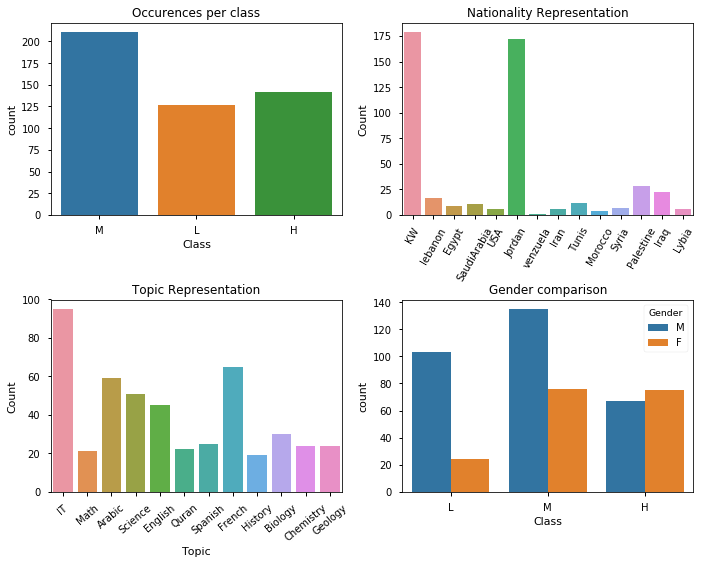

In [43]:
# basic data exploratory tasks
fig, axarr  = plt.subplots(2, 2, figsize=(10,8),)

cls = sns.countplot(x='Class',       data=df, ax=axarr[0,0])
cls.set(title='Occurences per class')
nat = sns.countplot(x='Nationality', data=df, ax=axarr[0,1])
nat.set(xlabel='', ylabel='Count', title='Nationality Representation')

plt.setp(nat.get_xticklabels(), rotation=60)


topic = sns.countplot(x='Topic', data=df, ax=axarr[1,0])
topic.set(xlabel='Topic', ylabel='Count', title='Topic Representation')

_ = plt.setp(topic.get_xticklabels(), rotation=40)
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

gen = sns.countplot(x='Class', hue='Gender', data=df, order=['L', 'M', 'H'], 
              ax=axarr[1,1])
_ = gen.set(title='Gender comparison')


A few conclusions on first look:
* The dataset is quite balanced. (first chart)  
* Most of our students are from Kuwait or Jordan. This was already mentioned in the description of the dataset, but it's nice to provide a visual.
* Topic representations are pretty good, but IT seems to dominate
* It looks like women performed better than men on average. Would the amount of visited resources in the online environment influence the final grade?


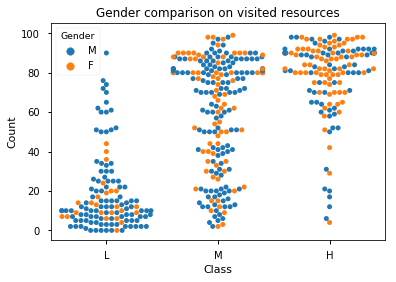

In [23]:
plot = sns.swarmplot(x='Class', y='VisitedResources', hue='Gender', order=['L', 'M', 'H'], 
              data=df)
plot.set(xlabel='Class', ylabel='Count', title='Gender comparison on visited resources')
plt.rcParams['figure.figsize']=(10,5)
plt.show()

This swarm plot shows us that students who received a lower grade (L) visited way fever resources than students that scored a M or H grade. Additionally, women who received a high mark (H) almost exclusively visited a lot of the online resources.

Let's dig a little bit deeper into other numerical variables.

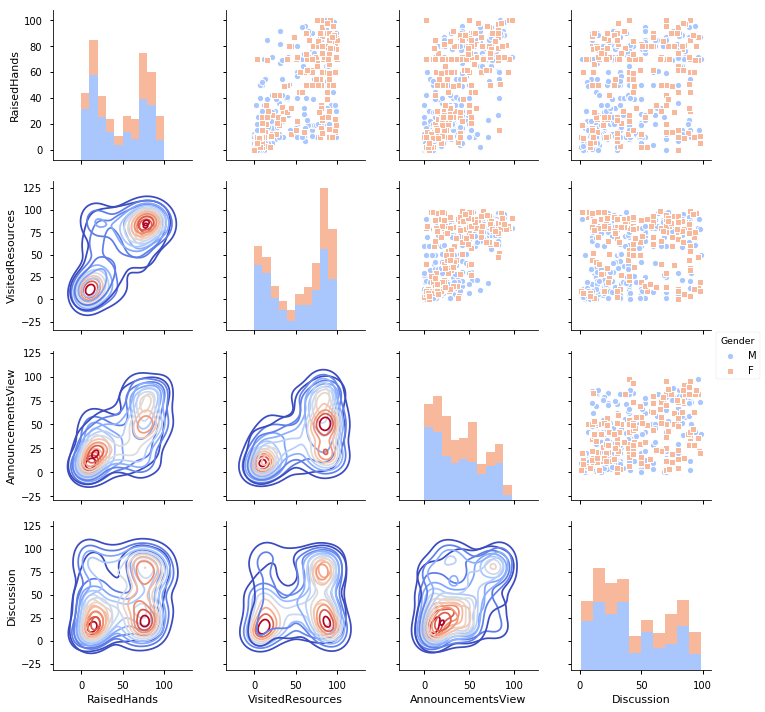

In [26]:
# Pairgrid, exploring our numerical variables
grd = sns.PairGrid(df, hue='Gender', palette='coolwarm', hue_kws={'marker': ['o', 's']})
grd = grd.map_diag(plt.hist)
grd = grd.map_upper(plt.scatter, linewidths=1, edgecolor='w', s=40)
grd = grd.map_lower(sns.kdeplot, lw=3, legend=False, cmap='coolwarm')
grd = grd.add_legend()

The plots show there are any specific relationships or patterns in the numerical data. However, when exploring the visited resources again we see that females generally visit more resources - clearly visible in the histogram.

<a id='traditional'></a>
## Tree-based models
Now we get to the model building bit. We will start by encoding our categorical variables and splitting the data into a train and test set.

In [27]:
X = df.drop('Class', axis=1)
y = df['Class']

# Encoding our categorical columns in X
labelEncoder = LabelEncoder()
cat_columns = X.dtypes.pipe(lambda x: x[x == 'object']).index
for col in cat_columns:
    X[col] = labelEncoder.fit_transform(X[col])

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Let's try decision tree and random forest:

In [29]:
keys = []
scores = []
models = {'Decision Tree': DecisionTreeClassifier(),
          'Random Forest': RandomForestClassifier(n_estimators=300, random_state=42)}

for k,v in models.items():
    mod = v
    mod.fit(X_train, y_train)
    pred = mod.predict(X_test)
    print('Results for: ' + str(k) + '\n')
    print(confusion_matrix(y_test, pred))
    print(classification_report(y_test, pred))
    acc = accuracy_score(y_test, pred)
    print("accuracy is "+ str(acc)) 
    print('\n' + '\n')
    keys.append(k)
    scores.append(acc)
    table = pd.DataFrame({'model':keys, 'accuracy score':scores})

print(table)


Results for: Random Forest

[[21  0  7]
 [ 0 31  3]
 [ 5  4 49]]
             precision    recall  f1-score   support

          H       0.81      0.75      0.78        28
          L       0.89      0.91      0.90        34
          M       0.83      0.84      0.84        58

avg / total       0.84      0.84      0.84       120

accuracy is 0.8416666666666667



Results for: Decision Tree

[[22  0  6]
 [ 0 29  5]
 [ 9  7 42]]
             precision    recall  f1-score   support

          H       0.71      0.79      0.75        28
          L       0.81      0.85      0.83        34
          M       0.79      0.72      0.76        58

avg / total       0.78      0.78      0.77       120

accuracy is 0.775



   accuracy score          model
0        0.841667  Random Forest
1        0.775000  Decision Tree


So, basic tree models (Random Forest) without any params tunning should get us to 84% Accuracy, which is inline with what Amrieh et. at. get in their papers.

For hierarchical models, this accuracy should be the goal.

<a id='hierarchical'></a>
## Hierarchical models
<a id='hier_logistic'></a>
[Motivation of why we should try Hierarchical models on this dataset is provided in **my 1st milestone.**](http://nbviewer.jupyter.org/github/nguyentu1602/et_submissions/blob/master/milestone1/notebook/Intermediate%20Milestone%201.ipynb)


For a very quick recap, in a hierarchical model, parameters are viewed as a sample from a population distribution of parameters. Thus, we view them as being neither entirely different or exactly the same. This is ***parital pooling***.

![hierarchical](http://f.cl.ly/items/1B3U223i002y3V2W3r0W/Screen%20Shot%202013-10-10%20at%208.25.05%20AM.png)

<a id='hier_logistic'></a>
## Hierarchical logistic model
In our example, the outcomes are categorical, so we need to fit a logistic model on the probabilities of student performance outcome.

Multiple hierarchies were tried, but for demonstration purpose, let's do just one level here. We'll used `Topic` where group-level parameters are grouped by a normal distribution. There are several reasons we use `Topic` here, but the main one is that hierarchical model only add value when the number of pooled groups >= 6 as suggested in [Gelman (2003).](http://www.stat.columbia.edu/~gelman/arm/)

In [46]:
df.columns

Index([u'Gender', u'Nationality', u'PlaceofBirth', u'StageID', u'GradeID',
       u'SectionID', u'Topic', u'Semester', u'Relation', u'RaisedHands',
       u'VisitedResources', u'AnnouncementsView', u'Discussion',
       u'ParentAnsweringSurvey', u'ParentschoolSatisfaction',
       u'StudentAbsenceDays', u'Class', u'TopicCode'],
      dtype='object')

In [45]:
# make a new column to map the Topic from ABCD to 0,1,2,3
df_old = df
dgroups = df.Topic.unique()
glookup = dict(zip(dgroups, range(len(dgroups))))
glookup

groups = df['TopicCode'] = df.Topic.replace(glookup).values 

In [91]:
# Data preparation
X = df.drop(['Class', 'TopicCode', 'Topic' ], axis=1)
X = pd.get_dummies(X,drop_first=True) # one-hot everything

y = df['Class']
y[y == 'M'] = 'H' # simplify signal
y = np.array((y == 'H').values, dtype=np.int)

# Train Test Split # TODO: correctly split the `groups` variable above here.
# for now use in-sample accuracy!  # train_test_split(X, y, test_size=0.25, random_state=42)
X_train = X_test = X
y_train = y_test = y

/Users/cuongnguyen/miniconda2/envs/stan27/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [93]:
print( X.columns.values)
X.head(2)

['RaisedHands' 'VisitedResources' 'AnnouncementsView' 'Discussion'
 'Gender_M' 'Nationality_Iran' 'Nationality_Iraq' 'Nationality_Jordan'
 'Nationality_KW' 'Nationality_Lybia' 'Nationality_Morocco'
 'Nationality_Palestine' 'Nationality_SaudiArabia' 'Nationality_Syria'
 'Nationality_Tunis' 'Nationality_USA' 'Nationality_lebanon'
 'Nationality_venzuela' 'PlaceofBirth_Iran' 'PlaceofBirth_Iraq'
 'PlaceofBirth_Jordan' 'PlaceofBirth_KuwaIT' 'PlaceofBirth_Lybia'
 'PlaceofBirth_Morocco' 'PlaceofBirth_Palestine'
 'PlaceofBirth_SaudiArabia' 'PlaceofBirth_Syria' 'PlaceofBirth_Tunis'
 'PlaceofBirth_USA' 'PlaceofBirth_lebanon' 'PlaceofBirth_venzuela'
 'StageID_MiddleSchool' 'StageID_lowerlevel' 'GradeID_G-04' 'GradeID_G-05'
 'GradeID_G-06' 'GradeID_G-07' 'GradeID_G-08' 'GradeID_G-09'
 'GradeID_G-10' 'GradeID_G-11' 'GradeID_G-12' 'SectionID_B' 'SectionID_C'
 'Semester_S' 'Relation_Mum' 'ParentAnsweringSurvey_Yes'
 'ParentschoolSatisfaction_Good' 'StudentAbsenceDays_Under-7']


,RaisedHands,VisitedResources,AnnouncementsView,Discussion,Gender_M,Nationality_Iran,Nationality_Iraq,Nationality_Jordan,Nationality_KW,Nationality_Lybia,Nationality_Morocco,Nationality_Palestine,Nationality_SaudiArabia,Nationality_Syria,Nationality_Tunis,Nationality_USA,Nationality_lebanon,Nationality_venzuela,PlaceofBirth_Iran,PlaceofBirth_Iraq,PlaceofBirth_Jordan,PlaceofBirth_KuwaIT,PlaceofBirth_Lybia,PlaceofBirth_Morocco,PlaceofBirth_Palestine,PlaceofBirth_SaudiArabia,PlaceofBirth_Syria,PlaceofBirth_Tunis,PlaceofBirth_USA,PlaceofBirth_lebanon,PlaceofBirth_venzuela,StageID_MiddleSchool,StageID_lowerlevel,GradeID_G-04,GradeID_G-05,GradeID_G-06,GradeID_G-07,GradeID_G-08,GradeID_G-09,GradeID_G-10,GradeID_G-11,GradeID_G-12,SectionID_B,SectionID_C,Semester_S,Relation_Mum,ParentAnsweringSurvey_Yes,ParentschoolSatisfaction_Good,StudentAbsenceDays_Under-7
0,15,16,2,20,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1
1,20,20,3,25,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1


In [97]:
# Now how do I fit a hierarchical logistic model here?
# check section 9.9 in the STAN manual for instructions
hier_log_reg_model = """data {
    // number of observations
    int<lower=0> N;
    
    // number of level
    int<lower=1> L;
    
    // target vector - equivalent to y[N] in the Manual
    int y[N];
    
    // number of predictors - equivalent to D in the Manual
    int K;
    
    // features matrix
    matrix[N, K] X;
    
    // what is ll? actual vector of ll
    int<lower=1, upper=L> ll[N];
}
transformed data {
}
parameters {
  // regression coefficient vector
  real mu[K];
  real<lower=0> sigma[K];  
  vector[K] beta[L];
}

model {    
    for (d in 1:K){
        mu[d] ~ normal(0, 100);
        for (l in 1:L){
            beta[l, d] ~ normal(mu[d], sigma[d]);
        }
    }
    
    for(n in 1:N) {
        y[n] ~ bernoulli(inv_logit(X[n] * beta[ll[n]]));
  }
}
"""

# precompile the model object here
sm_hier_lr = pystan.StanModel(model_code=hier_log_reg_model)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_83bb7f98be929e548dbf404bc93bfc85 NOW.


In [106]:
# # now make the data specifically to STAN
# X_vals = X_train[[u'Gender', u'Nationality', u'PlaceofBirth', u'StageID', u'GradeID',
#        u'SectionID', u'Semester', u'Relation', u'RaisedHands',
#        u'VisitedResources', u'AnnouncementsView', u'Discussion',
#        u'ParentAnsweringSurvey', u'ParentschoolSatisfaction',
#        u'StudentAbsenceDays']]

# X_vals = X_train[[u'Gender', 
#                   u'Nationality', 
#                   u'PlaceofBirth', 
#                   u'StageID', u'GradeID',
#                   u'SectionID', 
#                   u'Semester', 
#                   u'Relation', u'RaisedHands',
#        u'VisitedResources', u'AnnouncementsView', u'Discussion',
#        u'ParentAnsweringSurvey', u'ParentschoolSatisfaction',
#        u'StudentAbsenceDays']]

X_train_sub = X_train[['RaisedHands' 'VisitedResources' 'AnnouncementsView' 'Discussion'
 'Gender_M' 'Nationality_Iran' 'Nationality_Iraq' 'Nationality_Jordan'
#  'Nationality_KW' 'Nationality_Lybia' 'Nationality_Morocco'
#  'Nationality_Palestine' 'Nationality_SaudiArabia' 'Nationality_Syria'
#  'Nationality_Tunis' 'Nationality_USA' 'Nationality_lebanon'
#  'Nationality_venzuela' 'PlaceofBirth_Iran' 'PlaceofBirth_Iraq'
#  'PlaceofBirth_Jordan' 'PlaceofBirth_KuwaIT' 'PlaceofBirth_Lybia'
#  'PlaceofBirth_Morocco' 'PlaceofBirth_Palestine'
#  'PlaceofBirth_SaudiArabia' 'PlaceofBirth_Syria' 'PlaceofBirth_Tunis'
#  'PlaceofBirth_USA' 'PlaceofBirth_lebanon' 'PlaceofBirth_venzuela'
]]

hier_log_reg_dat = {
            'N': len(y_train),
            'y': y_train,
            'll': groups + 1,
            'L': len(glookup),
            'K': X_train_sub.shape[1],
            'X': X_train_sub.values,
}

KeyError: "['RaisedHandsVisitedResourcesAnnouncementsViewDiscussionGender_MNationality_IranNationality_IraqNationality_Jordan'] not in index"

In [107]:
# hier_log_reg_dat

In [108]:
# fit the data using the precompiled model object
fit3 = sm_hier_lr.sampling(data=hier_log_reg_dat, iter=1000, chains=2)

RuntimeError: Initialization failed.

Coding up a new model in STAN - adding my own annotations for understanding STAN syntax:

In [21]:
# same data as before - county awareness
partial_pooling_data = """
data {
  int<lower=0> N; 
  int<lower=1,upper=85> county[N];
  vector[N] y;
} """

# params: still 85 a[j] as average radon level per county to be estimated.
# these 85 a[j] comes from a distribution: N(mu_a, sigma_a)
# mu_a comes from a distribution also, but its distribution is assumed to be known.
# y_hat for any observation i is just the county level a[j] where observation y[i] belongs to. 
# y_hat[i] is the mean of the model's belief on y[i]. The model believes that y[i] follows a normal distribution
# centered around y_hat[i]
# so, does sigma_a and sigma_y got their distributions too?
partial_pooling_params = """
parameters {
  vector[85] a;
  real mu_a;
  real<lower=0, upper=100> sigma_a;
  real<lower=0, upper=100> sigma_y;
} 
transformed parameters {
  vector[N] y_hat;
  for (i in 1:N)
    y_hat[i] <- a[county[i]];
}"""

# 
partial_pooling_model = """
model {
  mu_a ~ normal(0, 1);
  a ~ normal(10 * mu_a, sigma_a);
  y ~ normal(y_hat,     sigma_y);
}"""
partial_pooling = partial_pooling_data + partial_pooling_params + partial_pooling_model

Notice now we have two standard deviations, one describing the residual error of the observations, and another the variability of the county means around the average.

In [22]:
partial_pool_data = {'N': len(log_radon),
                     'county': counties+1, # Stan counts starting at 1
                     'y': log_radon}

# so if I have 2 fixed distributions for sigma_a and sigma_y, and I run 4 chains at 1000 iterations, then I ended up
# with 4000 samples, divided by 2 hyper params (sigma_a, sigma_y), so I got 2000 each. 
partial_pool_fit = pystan.stan(model_code=partial_pooling, data=partial_pool_data, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c8e0453594a517d69f2b6e4879ae67e7 NOW.


In [23]:
# check out the fit results
partial_pool_samples = partial_pool_fit.extract(permuted=True)

print(partial_pool_samples.keys())

# does sigma_a and sigma_y follow distributions? - yes they have hyper params samples, that were sampled from 
# our given distributions. Each of sigma_a and sigma_y have 4*1000/2 = 2000 samples each
for k in partial_pool_samples.keys():
    print(k, partial_pool_samples[k].shape)

[u'a', u'mu_a', u'sigma_a', u'sigma_y', u'y_hat', u'lp__']
(u'a', (2000, 85))
(u'mu_a', (2000,))
(u'sigma_a', (2000,))
(u'sigma_y', (2000,))
(u'y_hat', (2000, 919))
(u'lp__', (2000,))


In [24]:
sample_trace = partial_pool_samples['a']  # retrieve the 2000x85 matrix of samples for the 85 counties' average levels 

samples, n_counties = sample_trace.shape
jitter = np.random.normal(scale=0.1, size=n_counties) # make 85 jitters

n_county = srrs_mn.groupby('county')['idnum'].count() # number of observations by county - bad var name really
unpooled_means = srrs_mn.groupby('county')['log_radon'].mean()  # empirical means by county
unpooled_sd = srrs_mn.groupby('county')['log_radon'].std()      # std by county
unpooled = pd.DataFrame({'n': n_county, 'mean_j': unpooled_means, 'sd': unpooled_sd})
unpooled['se'] = unpooled.sd/np.sqrt(unpooled.n)
unpooled.head(3)
# [ctrl shft -] to split a cell


,mean_j,n,sd,se
county,,,,
AITKIN,0.714935,4,0.431655,0.215828
ANOKA,0.890849,52,0.717729,0.099531
BECKER,1.090008,3,0.717105,0.414021


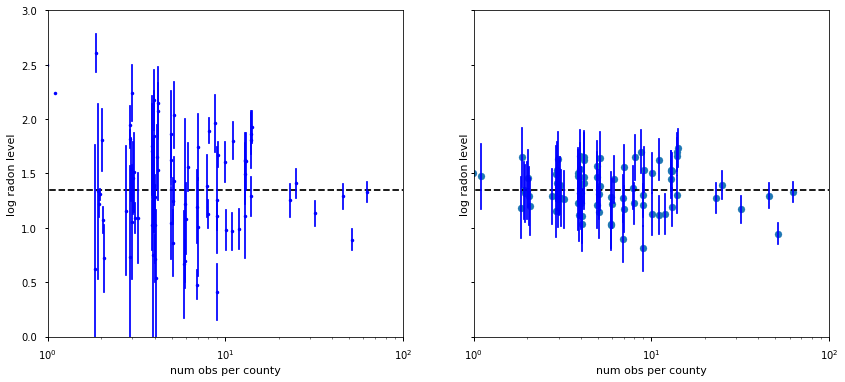

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(14,6), sharex=True, sharey=True) # 1 by 2 plots
for axe in axes:
    axe.set_ylabel('log radon level')
    axe.set_xlabel('num obs per county')
    
# left plot is about the unpooled model
axes[0].plot(unpooled.n + jitter, unpooled.mean_j, 'b.')
        
for jit, row in zip(jitter, unpooled.iterrows()):
    name, dat = row
    axes[0].plot([dat.n + jit, dat.n+jit], [dat.mean_j - dat.se, dat.mean_j + dat.se], 'b-')
axes[0].set_xscale('log')
axes[0].hlines(sample_trace.mean(), 0.9, 100, linestyles='--')


# right plot is the partial pooled model
samples, pp_counties = sample_trace.shape
pp_means = sample_trace.mean(axis=0)
pp_sd    = sample_trace.std(axis=0)

axes[1].scatter(n_county.values + jitter, pp_means) # ploting the estimation and the se against the number of samples
axes[1].set_xscale('log')
axes[1].set_xlim(1,100)
axes[1].set_ylim(0, 3)
axes[1].hlines(sample_trace.mean(), 0.9, 100, linestyles='--')
for jit, n, m, s in zip(jitter, n_county.values, pp_means, pp_sd):
    axes[1].plot([n+jit]*2, [m-s, m+s], 'b-')

Notice the difference between the unpooled and partially-pooled estimates, particularly at smaller sample sizes. The former are both more extreme and more imprecise.

<a id='intercept'></a>
## Varying intercept model

This model allows intercepts to vary across county, according to a random effect.

$$y_i = \alpha_{j[i]} + \beta x_{i} + \epsilon_i$$

where

$$\epsilon_i \sim N(0, \sigma_y^2)$$

and the intercept random effect:

$$\alpha_{j[i]} \sim N(\mu_{\alpha}, \sigma_{\alpha}^2)$$

As with the the “no-pooling” model, we set a separate intercept for each county, but rather than fitting separate least squares regression models for each county, multilevel modeling **shares strength** among counties, allowing for more reasonable inference in counties with little data.

In [34]:
# a[J] below is a vector of 85 intercepts. All counties share slope beta though
varying_intercept = """
data {
  int<lower=0> J; 
  int<lower=0> N; 
  int<lower=1,upper=J> county[N];
  vector[N] x;
  vector[N] y;
}
parameters {
  vector[J] a;
  real b;
  real mu_a;
  real<lower=0,upper=100> sigma_a;
  real<lower=0,upper=100> sigma_y;
} 
transformed parameters {
  vector[N] y_hat;

  for (i in 1:N)
    y_hat[i] <- a[county[i]] + x[i] * b;
}
model {
  sigma_a ~ uniform(0, 100);
  a ~ normal (mu_a, sigma_a);

  b ~ normal (0, 1);
  sigma_y ~ uniform(0, 100);
  y ~ normal(y_hat, sigma_y);
}
"""

In [36]:
# counties+1

In [37]:
varying_intercept_data = {'N': len(log_radon),
                          'J': len(n_county),
                          'county': counties+1, # Stan counts starting at 1
                          'x': floor_measure,
                          'y': log_radon}

varying_intercept_fit = pystan.stan(model_code=varying_intercept, 
                                    data=varying_intercept_data, 
                                    iter=500, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5ae70772ae0d3782d483dfc90185c54a NOW.


Check out the fit results:

In [38]:
varying_intercept_samples = varying_intercept_fit.extract(permuted=True)

# does sigma_a and sigma_y follow distributions? - yes they have hyper params samples, that were sampled from 
# our given distributions. Each of sigma_a and sigma_y have 4*500/2 = 1000 samples each
for k in varying_intercept_samples.keys():
    print(k, varying_intercept_samples[k].shape)

(u'a', (1000, 85))
(u'b', (1000,))
(u'mu_a', (1000,))
(u'sigma_a', (1000,))
(u'sigma_y', (1000,))
(u'y_hat', (1000, 919))
(u'lp__', (1000,))


In [39]:
a_sample = pd.DataFrame(varying_intercept_fit['a']) # this is the sampled intercepts
print(a_sample.shape)
a_sample.head(2) 

(1000, 85)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84
0,1.082422,1.058004,1.734270,1.492086,1.358398,1.406230,1.943877,1.774761,0.772445,1.366874,1.512748,1.668031,1.602897,1.852146,1.646659,1.322130,1.311861,1.266367,1.537163,1.984217,1.529966,1.050980,1.633485,1.871178,1.793719,1.449705,1.884050,1.642878,1.135240,1.246178,1.972902,1.847535,1.535712,0.860269,0.756906,2.030800,0.629727,1.370245,1.846910,1.945228,1.909140,1.488804,1.523520,1.247354,1.282879,1.059876,1.400392,1.452163,1.535878,1.767895,1.933285,1.466436,1.882584,1.19844,1.670203,1.771253,1.071908,1.719325,1.303071,1.428890,1.393432,1.814194,1.469877,1.959447,1.365255,1.628557,2.038841,1.340603,1.670472,0.996904,1.534244,1.663160,1.268191,1.62114,1.726118,1.216302,1.458240,1.390693,0.774775,1.461193,1.874888,1.469073,1.700370,1.958431,1.486757
1,1.127920,0.935661,1.644668,1.526243,1.245810,1.152144,1.710041,1.673399,1.221769,1.612751,1.465221,1.403966,0.941125,1.821013,1.423168,1.195232,1.301983,1.246549,1.356761,1.525650,1.601590,0.795559,1.582695,2.074278,1.596958,1.384086,1.805848,1.422327,1.587785,0.896091,1.996473,1.195974,2.073429,1.604419,0.893467,1.634498,0.710588,1.653079,1.516513,1.967236,1.745776,1.671786,1.596316,1.226464,1.302338,1.250461,1.444646,1.732138,1.651074,1.540146,1.696602,1.795763,1.863933,1.24914,1.447016,1.502441,0.750137,1.442784,1.683782,1.915237,1.218406,1.944339,1.544285,1.938306,1.158757,1.731987,1.673943,1.192510,1.132091,0.957782,1.507512,1.285554,1.455254,1.17137,1.768457,2.094600,1.678572,1.618379,1.028263,1.302268,1.513467,1.934788,1.558909,1.443843,1.452721


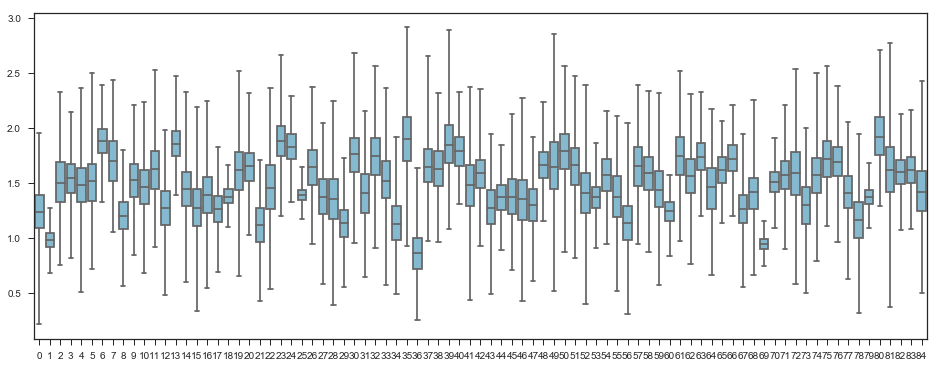

In [40]:
import seaborn as sns
sns.set(style="ticks", palette="muted", color_codes=True)

# Plot the orbital period with horizontal boxes
fig = plt.figure(figsize=(16, 6))
sns.boxplot(data=a_sample, whis=np.inf, color="c")
fig.axes[0]

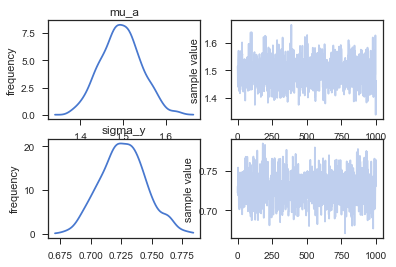

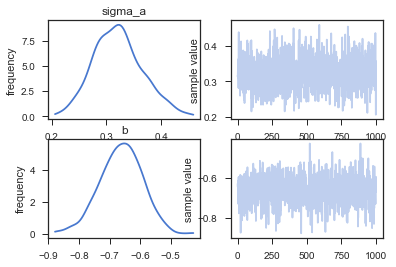

In [41]:
# the fit object from stan got plot method on them too - Visualize samples from posterior distributions
# varying_intercept_fit.plot.__doc__
varying_intercept_fit.plot(pars=['mu_a', 'sigma_y']);
varying_intercept_fit.plot(pars=['sigma_a', 'b']);

The estimate for the `floor` coefficient is approximately -0.66, which can be interpreted as houses without basements having about half ($\exp(-0.66) = 0.52$) the radon levels of those with basements, after accounting for county.

In [42]:
varying_intercept_fit['b'].mean()  # mean of the posterior distributions of beta (floor coef)

-0.6621689473408569

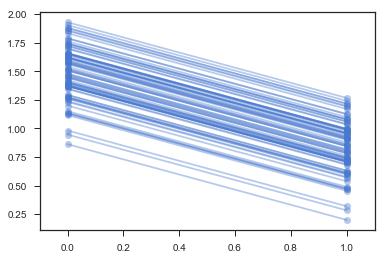

In [43]:
xvals = np.arange(2)
bp = varying_intercept_fit['a'].mean(axis=0)
mp = varying_intercept_fit['b'].mean()
for bi in bp:
    plt.plot(xvals, mp*xvals + bi, 'bo-', alpha=0.4)
plt.xlim(-0.1,1.1);

It is easy to show that the partial pooling model provides more objectively reasonable estimates than either the pooled or unpooled models, at least for counties with small sample sizes.

/Users/cuongnguyen/miniconda2/envs/stan27/lib/python2.7/site-packages/pandas/core/series.py:705: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


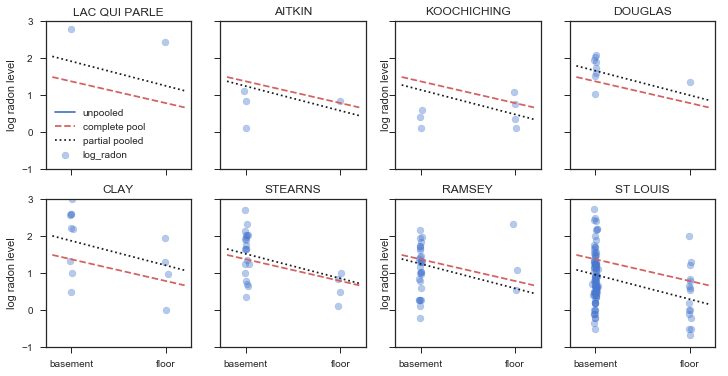

In [44]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()
for i,c in enumerate(sample_counties):
    
    # Plot county data
    y = srrs_mn.log_radon[srrs_mn.county==c]
    x = srrs_mn.floor[srrs_mn.county==c]
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)
    
    # No pooling model
    m,b = unpooled_estimates[['floor', c]]
    
    xvals = np.linspace(-0.2, 1.2)
    # Unpooled estimate
    axes[i].plot(xvals, m*xvals+b, label='unpooled')
    # Pooled estimate
    axes[i].plot(xvals, m0*xvals+b0, 'r--', label='complete pool')
    # Partial pooling esimate
    axes[i].plot(xvals, mp*xvals+bp[county_lookup[c]], 'k:', label='partial pooled')
    axes[i].set_xticks([0,1])
    axes[i].set_xticklabels(['basement', 'floor'])
    axes[i].set_ylim(-1, 3)
    axes[i].set_title(c)
    if not i%2:
        axes[i].set_ylabel('log radon level')
    if i == 0:
        axes[i].legend(loc='lower left')

<a id='slope'></a>
## Varying slope model

Alternatively, we can posit a model that allows the counties to vary according to how the location of measurement (basement or floor) influences the radon reading.

$$y_i = \alpha + \beta_{j[i]} x_{i} + \epsilon_i$$


In [45]:
varying_slope = """
data {
  int<lower=0> J; 
  int<lower=0> N; 
  int<lower=1,upper=J> county[N];
  vector[N] x;
  vector[N] y;
} 
parameters {
  real a;
  vector[J] b;
  real mu_b;
  real<lower=0,upper=100> sigma_b;
  real<lower=0,upper=100> sigma_y;
} 
transformed parameters {

  vector[N] y_hat;

  for (i in 1:N)
    y_hat[i] <- a + x[i] * b[county[i]];
}
model {
  sigma_b ~ uniform(0, 100);
  b ~ normal (mu_b, sigma_b);

  a ~ normal (0, 1);

  sigma_y ~ uniform(0, 100);
  y ~ normal(y_hat, sigma_y);
}
"""

In [46]:
varying_slope_data = {'N': len(log_radon),
                          'J': len(n_county),
                          'county': counties+1, # Stan counts starting at 1
                          'x': floor_measure,
                          'y': log_radon}

varying_slope_fit = pystan.stan(model_code=varying_slope, data=varying_slope_data, 
                                iter=1000, chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_450bb1b9a4b2905be56a9a4fe472e0fd NOW.


In [47]:
b_sample = pd.DataFrame(varying_slope_fit['b'])

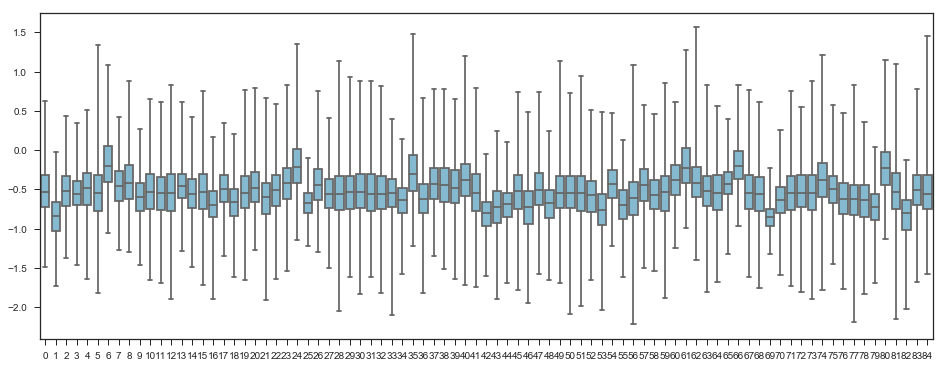

In [48]:
# Plot the orbital period with horizontal boxes
plt.figure(figsize=(16, 6))
sns.boxplot(data=b_sample, whis=np.inf, color="c")

We can visualize a single intercept with multiple slopes here:

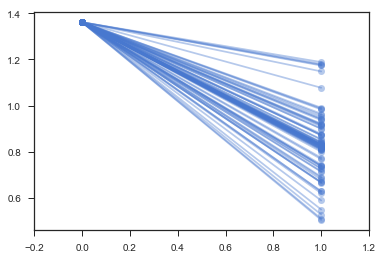

In [51]:
xvals = np.arange(2)
b = varying_slope_fit['a'].mean()
m = varying_slope_fit['b'].mean(axis=0)
for mi in m:
    plt.plot(xvals, mi*xvals + b, 'bo-', alpha=0.4)
plt.xlim(-0.2, 1.2);

<a id='intercept_and_slope'></a>
## Varying intercept and slope model

The most general model allows both the intercept and slope to vary by county:

$$y_i = \alpha_{j[i]} + \beta_{j[i]} x_{i} + \epsilon_i$$


In [52]:
varying_intercept_slope = """
data {
  int<lower=0> N;
  int<lower=0> J;
  vector[N] y;
  vector[N] x;
  int county[N];
}
parameters {
  real<lower=0> sigma;
  real<lower=0> sigma_a;
  real<lower=0> sigma_b;
  vector[J] a;
  vector[J] b;
  real mu_a;
  real mu_b;
}

model {
  mu_a ~ normal(0, 100);
  mu_b ~ normal(0, 100);

  a ~ normal(mu_a, sigma_a);
  b ~ normal(mu_b, sigma_b);
  y ~ normal(a[county] + b[county].*x, sigma);
}
"""

In [53]:
varying_intercept_slope_data = {'N': len(log_radon),
                          'J': len(n_county),
                          'county': counties+1, # Stan counts starting at 1
                          'x': floor_measure,
                          'y': log_radon}

# This pystan.stan() is slow because it compile stan model into C++ code
varying_intercept_slope_fit = pystan.stan(model_code=varying_intercept_slope, 
                                          data=varying_intercept_slope_data, 
                                          iter=1000, chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fb7a52c607796d20fe4b3a9a309cb1eb NOW.


Across counties, we have different slope AND different intercepts:

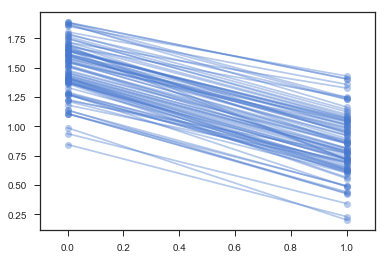

In [54]:
xvals = np.arange(2)
b = varying_intercept_slope_fit['a'].mean(axis=0)
m = varying_intercept_slope_fit['b'].mean(axis=0)
for bi,mi in zip(b,m):
    plt.plot(xvals, mi*xvals + bi, 'bo-', alpha=0.4)
plt.xlim(-0.1, 1.1);

<a id='grouplevel'></a>
## Adding group-level predictors

A primary strength of multilevel models is the ability to handle predictors on multiple levels simultaneously. If we consider the varying-intercepts model above:

$$y_i = \alpha_{j[i]} + \beta x_{i} + \epsilon_i$$

we may, instead of a simple random effect to describe variation in the expected radon value, specify another regression model with a county-level covariate. Here, we use the county uranium reading $u_j$, which is thought to be related to radon levels:

$$\alpha_j = \gamma_0 + \gamma_1 u_j + \zeta_j$$

$$\zeta_j \sim N(0, \sigma_{\alpha}^2)$$

Thus, we are now incorporating a house-level predictor (floor or basement) as well as a county-level predictor (uranium).

Note that the model has both indicator variables for each county, plus a county-level covariate. In classical regression, this would result in collinearity. In a multilevel model, the partial pooling of the intercepts towards the expected value of the group-level linear model avoids this.

Group-level predictors also serve to reduce group-level variation $\sigma_{\alpha}$. An important implication of this is that the group-level estimate induces stronger pooling.

In [55]:
hierarchical_intercept = """
data {
  int<lower=0> J; 
  int<lower=0> N; 
  int<lower=1,upper=J> county[N];
  vector[N] u;
  vector[N] x;
  vector[N] y;
} 
parameters {
  vector[J] a;
  vector[2] b;
  real mu_a;
  real<lower=0,upper=100> sigma_a;
  real<lower=0,upper=100> sigma_y;
} 
transformed parameters {
  vector[N] y_hat;
  vector[N] m;

  for (i in 1:N) {
    m[i] <- a[county[i]] + u[i] * b[1];
    y_hat[i] <- m[i] + x[i] * b[2];
  }
}
model {
  mu_a ~ normal(0, 1);
  a ~ normal(mu_a, sigma_a);
  b ~ normal(0, 1);
  y ~ normal(y_hat, sigma_y);
}
"""

In [56]:
hierarchical_intercept_data = {'N': len(log_radon),
                          'J': len(n_county),
                          'county': counties+1, # Stan counts starting at 1
                          'u': u,
                          'x': floor_measure,
                          'y': log_radon}

hierarchical_intercept_fit = pystan.stan(model_code=hierarchical_intercept, data=hierarchical_intercept_data, 
                                         iter=1000, chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_09c24493b150e61b5f7babd2ed515f09 NOW.


Text(0,0.5,'Intercept estimate')

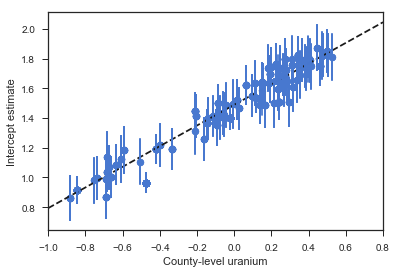

In [57]:
#a_means = M_hierarchical.a.trace().mean(axis=0)
m_means = hierarchical_intercept_fit['m'].mean(axis=0)
plt.scatter(u, m_means)
g0 = hierarchical_intercept_fit['mu_a'].mean()
g1 = hierarchical_intercept_fit['b'][:, 0].mean()
xvals = np.linspace(-1, 0.8)
plt.plot(xvals, g0+g1*xvals, 'k--')
plt.xlim(-1, 0.8)

m_se = hierarchical_intercept_fit['m'].std(axis=0)
for ui, m, se in zip(u, m_means, m_se):
    plt.plot([ui,ui], [m-se, m+se], 'b-')
plt.xlabel('County-level uranium'); plt.ylabel('Intercept estimate')

The standard errors on the intercepts are narrower than for the partial-pooling model without a county-level covariate (covariate==variable).

<a id='correlations'></a>
### Correlations among levels

In some instances, having predictors at multiple levels can reveal correlation between individual-level variables and group residuals. We can account for this by including the average of the individual predictors as a covariate in the model for the group intercept.

$$\alpha_j = \gamma_0 + \gamma_1 u_j + \gamma_2 \bar{x} + \zeta_j$$

These are broadly referred to as ***contextual effects***.

In [58]:
# Create new variable for mean of floor across counties
xbar = srrs_mn.groupby('county')['floor'].mean().rename(county_lookup).values

In [59]:
x_mean = xbar[counties]

In [60]:
contextual_effect = """
data {
  int<lower=0> J; 
  int<lower=0> N; 
  int<lower=1,upper=J> county[N];
  vector[N] u;
  vector[N] x;
  vector[N] x_mean;
  vector[N] y;
} 
parameters {
  vector[J] a;
  vector[3] b;
  real mu_a;
  real<lower=0,upper=100> sigma_a;
  real<lower=0,upper=100> sigma_y;
} 
transformed parameters {
  vector[N] y_hat;

  for (i in 1:N)
    y_hat[i] <- a[county[i]] + u[i]*b[1] + x[i]*b[2] + x_mean[i]*b[3];
}
model {
  mu_a ~ normal(0, 1);
  a ~ normal(mu_a, sigma_a);
  b ~ normal(0, 1);
  y ~ normal(y_hat, sigma_y);
}
"""

In [61]:
contextual_effect_data = {'N': len(log_radon),
                          'J': len(n_county),
                          'county': counties+1, # Stan counts starting at 1
                          'u': u,
                          'x_mean': x_mean,
                          'x': floor_measure,
                          'y': log_radon}

contextual_effect_fit = pystan.stan(model_code=contextual_effect, data=contextual_effect_data, 
                                         iter=1000, chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b7928e9396770558600f70afccda0012 NOW.


In [62]:
contextual_effect_fit['b'].mean(0)

array([ 0.69048456, -0.68536569,  0.38878779])

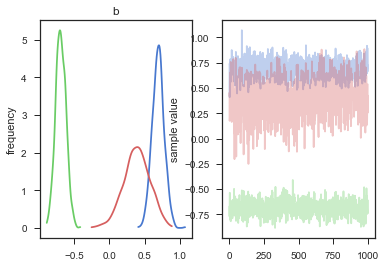

In [63]:
contextual_effect_fit.plot('b');

So, we might infer from this that counties with higher proportions of houses without basements tend to have higher baseline levels of radon. Perhaps this is related to the soil type, which in turn might influence what type of structures are built.

<a id='prediction'></a>
### Prediction
There are two types of prediction that can be made in a multilevel model:

1. a new individual within an existing group
2. a new individual within a new group

For example, if we wanted to make a prediction for a new house with no basement in St. Louis county, we just need to sample from the radon model with the appropriate intercept.

In [64]:
county_lookup['ST LOUIS']

69

That is, 
$$\tilde{y}_i \sim N(\alpha_{69} + \beta (x_i=1), \sigma_y^2)$$

This is simply a matter of adding a single additional line in PyStan:

In [65]:
contextual_pred = """
data {
  int<lower=0> J; 
  int<lower=0> N; 
  int<lower=0,upper=J> stl;
  real u_stl;
  real xbar_stl;
  int<lower=1,upper=J> county[N];
  vector[N] u;
  vector[N] x;
  vector[N] x_mean;
  vector[N] y;
} 
parameters {
  vector[J] a;
  vector[3] b;
  real mu_a;
  real<lower=0,upper=100> sigma_a;
  real<lower=0,upper=100> sigma_y;
} 
transformed parameters {
  vector[N] y_hat;
  real stl_mu;

  for (i in 1:N)
    y_hat[i] <- a[county[i]] + u[i] * b[1] + x[i] * b[2] + x_mean[i] * b[3];
    
  stl_mu <- a[stl+1] + u_stl * b[1] + b[2] + xbar_stl * b[3];
 }
model {
  mu_a ~ normal(0, 1);
  a ~ normal(mu_a, sigma_a);
  b ~ normal(0, 1);
  y ~ normal(y_hat, sigma_y);
}
generated quantities {
  real y_stl;
  
  y_stl <- normal_rng(stl_mu, sigma_y);
}
"""

In [66]:
contextual_pred_data = {'N': len(log_radon),
                          'J': len(n_county),
                          'county': counties+1, # Stan counts starting at 1
                          'u': u,
                          'x_mean': x_mean,
                          'x': floor_measure,
                          'y': log_radon,
                          'stl': 69,
                          'u_stl': np.log(cty_mn[cty_mn.cty=='STLOUIS'].Uppm.values)[0],
                          'xbar_stl': xbar[69]}

In [67]:
contextual_pred_fit = pystan.stan(model_code=contextual_pred, data=contextual_pred_data, 
                                         iter=1000, chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e5df54feeaee9fa3eefb787ac27e9aa6 NOW.


We can see that our prediction for `log_radon` level for a new house in ST_LOUIS without a basement is around 0.5, with the full spectrum of prediction uncertainty specified by the sampling distribution:

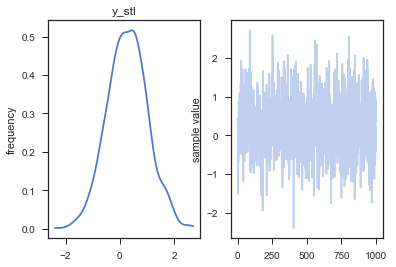

In [68]:
contextual_pred_fit.plot('y_stl');

## References

Gelman, A., & Hill, J. (2006). Data Analysis Using Regression and Multilevel/Hierarchical Models (1st ed.). Cambridge University Press.

Gelman, A. (2006). Multilevel (Hierarchical) modeling: what it can and cannot do. Technometrics, 48(3), 432–435.